## Mood Detector With Tensorflow

In [27]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf  # Correct way to import TensorFlow
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential, save_model, Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

The next code defines our image input size, batch size (how many images are processed at once), number of color channels (RGB), and how many times the model will train on the full dataset (epochs).

In [28]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
# Lloading the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train_ds",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
    
)

print("The total batches in the dataset is", len(dataset))

Found 716 files belonging to 5 classes.
The total batches in the dataset is 23


In [6]:
# checking the class names
class_names = dataset.class_names
class_names

['Sad', 'Surprised', 'angry', 'happy', 'normal']

(32, 256, 256, 3)


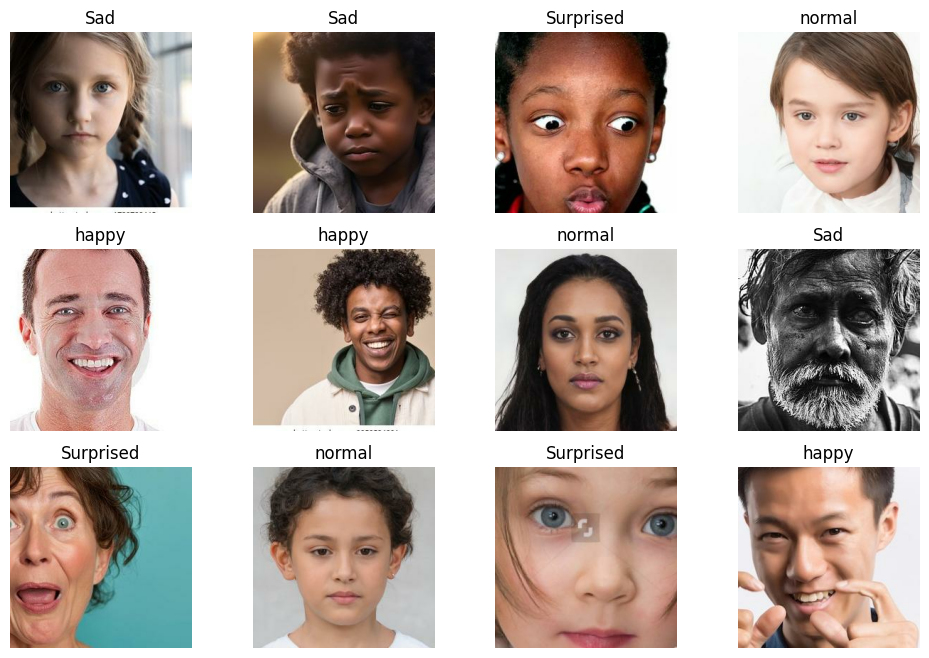

In [7]:
plt.figure(figsize = (12,8))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    for i in range(min(12, image_batch.shape[0])):
        ax= plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i].numpy()])
        plt.axis("off")
        


In [8]:
# Splitting the dataset into train, test and validation
# 80% training
# 10% validation 
# # 10% test

def get_dataset_partitions(ds, train_split=0.8, val_split=0.2, shuffle = True, shuffle_size= 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)  #seed is for predictability
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    
    
    
    return train_ds, val_ds

In [9]:
train_ds, val_ds = get_dataset_partitions(dataset)
len(train_ds), len(val_ds)

(18, 4)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [11]:
# preprocessing/scaling the images

resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), # Accepts image input of fixed shape
    layers.Rescaling(1.0/255),
    ])

In [12]:
# Data augmentation generates new images by slightly modifying existing ones
# This helps to prevent overfitting by providing more diverse training data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.2, 0.2)
])

In [19]:
input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5
model = models.Sequential([
    layers.Input(shape=input_shape),                # Input layer
    resize_and_rescale,
    data_augmentation,                                        # Data augmentation layer
    layers.Conv2D(32, (3,3), activation='relu'),    # 32 filters will be detected. kernel size of 3x3
    layers.MaxPooling2D((2,2)),                     #  Takes a small region and keeps the maximum value
    Dropout(0.5),                                   #prevents overfitting by making the model less reliant on any one neuron
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    Dropout(0.5),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    Dropout(0.5),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')   # output layer with softmax activation for multi-class classification
    ])

model.build(input_shape = (None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,453 (3.42 MB)

 Trainable params: 896,453 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# compile the model
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [23]:
#  The variable history is used to store the training history returned by model.fit
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
    #callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3072 - loss: 1.5479 - val_accuracy: 0.3203 - val_loss: 1.6007
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3172 - loss: 1.5733 - val_accuracy: 0.3203 - val_loss: 1.5982
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3232 - loss: 1.5644 - val_accuracy: 0.3203 - val_loss: 1.5939
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.3215 - loss: 1.5826 - val_accuracy: 0.3203 - val_loss: 1.5945
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3287 - loss: 1.5813 - val_accuracy: 0.3203 - val_loss: 1.5799
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.2879 - loss: 1.5895 - val_accuracy: 0.3203 - val_loss: 1.5756
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.2955 - loss: 1.5839 - val_accuracy: 0.3203 - val_loss: 1.5763
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.2929 - loss: 1.5781 - val_accuracy: 0.3203 - val_loss:

In [24]:
scores = model.evaluate(val_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.3875 - loss: 1.4707


In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))  # Instead of EPOCHS, in case EarlyStopping kicked in early

Text(0.5, 1.0, 'Training and Validation Loss')

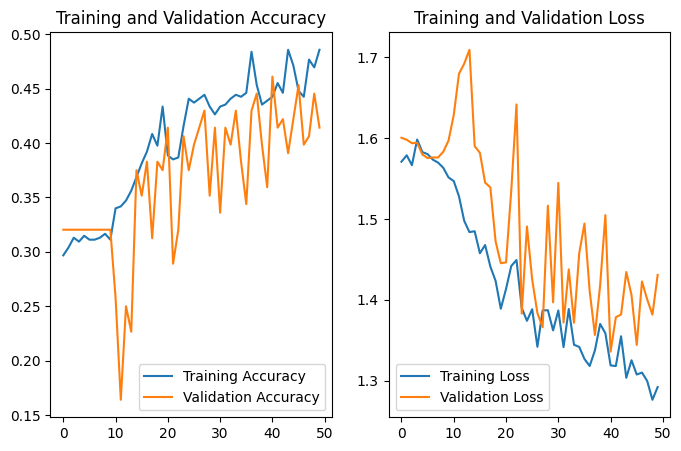

In [26]:
# graph showing the training and validation accuracy
plt.figure(figsize = (8,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# Graph showing the training loss and validation loss
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower left')
plt.title('Training and Validation Loss')


## Transfer Learning

In [29]:
input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

base_model = MobileNetV2(input_shape = input_shape, include_top = False, weights = 'imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
output = Dense(n_classes, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = output)

# Freeze base model
for layer in base_model.layers:
  layer.trainable  = False

model.compile(
    optimizer = Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)


C:\Users\NGARE\AppData\Local\Temp\ipykernel_2068\72601987.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape = input_shape, include_top = False, weights = 'imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 11s 1us/step


In [30]:
# Load data

train_dir = 'train_ds'
val_dir = 'val_ds'

In [31]:
for filename in os.listdir(train_dir):
  print(filename)

angry
happy
normal
Sad
Surprised


In [32]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 716 images belonging to 5 classes.
Found 158 images belonging to 5 classes.


In [49]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32
)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7678 - loss: 0.6852 - val_accuracy: 0.5781 - val_loss: 1.1516
Epoch 2/20
 1/22 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7500 - loss: 0.6666

c:\Users\NGARE\DS_Python_Lux\Ds_projects\CH2 PROJECT\Mood-Detector-With-TensorFlow\fvenv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.7500 - loss: 0.6666 - val_accuracy: 0.6016 - val_loss: 1.1284
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8126 - loss: 0.5885 - val_accuracy: 0.6016 - val_loss: 1.0466
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.7812 - loss: 0.7847 - val_accuracy: 0.5938 - val_loss: 1.1097
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8045 - loss: 0.6349 - val_accuracy: 0.5781 - val_loss: 1.0886
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.8125 - loss: 0.6294 - val_accuracy: 0.5938 - val_loss: 1.1066
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7734 - loss: 0.6169 - val_accuracy: 0.5938 - val_loss: 1.0823
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.8125 - loss: 0.5579 - val_accuracy: 0.5781 - val_loss: 1.0468
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8208 - loss: 0.5775 - val_accuracy: 0.6250 - val_loss: 0.

In [50]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.2f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6425 - loss: 0.8838
Validation Accuracy: 0.63


In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss= history.history['loss']
val_loss = history.history['val_loss']
epochs_range= range(len(acc))  # Instead of EPOCHS, in case EarlyStopping kicked in early

Text(0.5, 1.0, 'Training and Validation Loss')

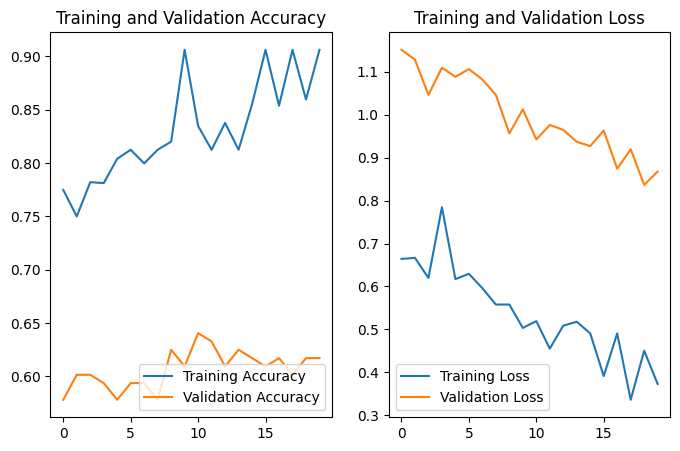

In [52]:
# graph showing the training and validation accuracy
plt.figure(figsize = (8,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# Graph showing the training loss and validation loss
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower left')
plt.title('Training and Validation Loss')

In [55]:
# (optional) Unfreeze and fine tune
# Unfreeze the last few layers of base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Compile again with a lower learning rate
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8938 - loss: 0.3487 - val_accuracy: 0.6899 - val_loss: 0.7430
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9026 - loss: 0.3319 - val_accuracy: 0.7025 - val_loss: 0.7410
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8956 - loss: 0.3497 - val_accuracy: 0.7215 - val_loss: 0.7048
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9211 - loss: 0.2862 - val_accuracy: 0.7405 - val_loss: 0.6939
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9122 - loss: 0.2983 - val_accuracy: 0.7532 - val_loss: 0.6727
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9466 - loss: 0.2685 - val_accuracy: 0.7722 - val_loss: 0.6525
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9331 - loss: 0.2837 - val_accuracy: 0.7911 - val_loss: 0.6373
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9453 - loss: 0.2381 - val_accuracy: 0.7975 - val_loss:

In [56]:
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7615 - loss: 0.6233
Validation Accuracy: 0.80


In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss= history.history['loss']
val_loss = history.history['val_loss']
epochs_range= range(len(acc))  # Instead of EPOCHS, in case EarlyStopping kicked in early

Text(0.5, 1.0, 'Training and Validation Loss')

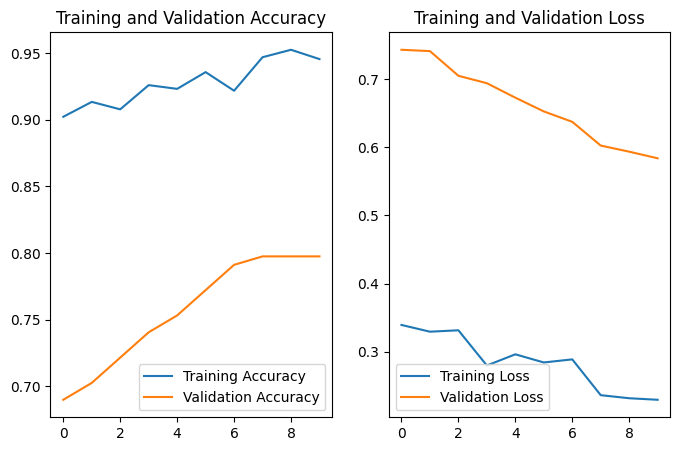

In [58]:
# graph showing the training and validation accuracy
plt.figure(figsize = (8,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# Graph showing the training loss and validation loss
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower left')
plt.title('Training and Validation Loss')